# VOC Segmaentation 데이터셋 사용하기
[참고 블로그](https://deep-learning-study.tistory.com/707)

In [ ]:
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
from albumentations import HorizontalFlip, Compose, Resize, Normalize
import os
import time

%matplotlib inline

In [ ]:
# 데이터셋을 저장할 폴더를 생성합니다.
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error')

createFolder('./data')

In [ ]:
# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [ ]:
# VOCSegmentation dataset 정의
class myVOCSegmentation(VOCSegmentation):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            augmented = self.transforms(image=np.array(img), mask=np.array(target))
            img = augmented['image']
            target = augmented['mask']
            target[target>20] = 0
        
        img = to_tensor(img)
        target = torch.from_numpy(target).type(torch.long)
        return img, target

In [ ]:
# transformation 정의
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
h,w = 520, 520

transform_tran = Compose([Resize(h,w),
                          HorizontalFlip(p=0.5),
                          Normalize(mean=mean, std=std)
                          ])

transform_val = Compose([Resize(h,w),
                         Normalize(mean=mean, std=std)
                        ])

In [ ]:
# myVOCSegmentation dataset 불러옴
path2data = './data'
train_ds = myVOCSegmentation(path2data, year='2012', image_set='train', download=True, transforms=transform_tran)
val_ds = myVOCSegmentation(path2data, year='2012', image_set='val', download=True, transforms=transform_val)

print(len(train_ds))
print(len(val_ds))

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
1464
1449


In [ ]:
# 샘플 이미지 확인
np.random.seed(0)
num_classes = 21
COLORS = np.random.randint(0, 2, size=(num_classes+1,3), dtype='uint8')

# 이미지와 마스크를 함께 시각화하는 함수를 정의
def show_img_target(img, target):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        target=target.numpy()
    for ll in range(num_classes):
        mask=(target==ll)
        img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

In [ ]:
# re-normalize 함수 정의
def re_normalize(x, mean=mean, std=std):
    x_r = x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean,std)):
        x_r[c] *= std_c
        x_r[c] += mean_c
    return x_r


In [ ]:
# 샘플 이미지 얻음
img, mask = train_ds[6]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6400)
torch.Size([520, 520]) torch.LongTensor tensor(4)


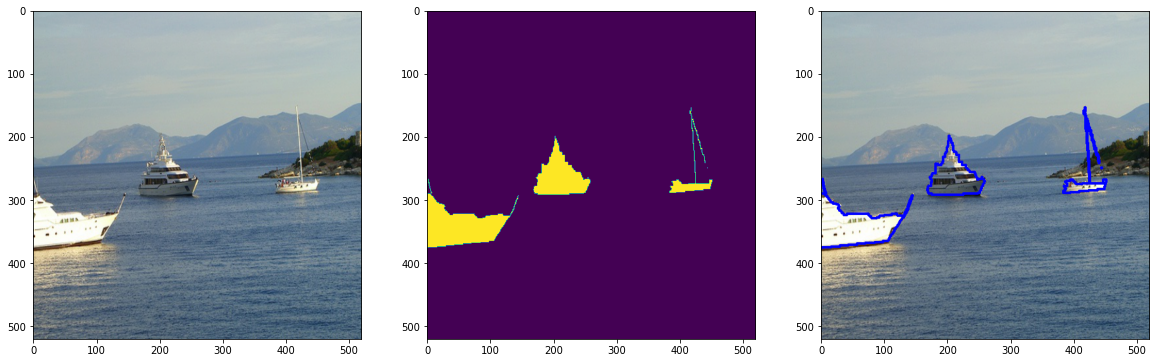

In [ ]:
# 샘플 이미지 시각화
plt.figure(figsize=(20,20))

img_r = re_normalize(img)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img_r))

plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
show_img_target(img_r, mask)